In [1]:
#__autho__:Ziman Z
#__date__:Apr30
# this notebook group the census tract based on the proportion of complaint counts by each hour of the day
# please refer corresponding cells and copy paste to the head of your notebook to avoid redundant data cleaning!

import pandas as pd
import numpy as np
import os
import seaborn as sns
sns.set_style(style='white')

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster   # flat cluster

import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
import geojson
import fiona
%pylab inline
cwd = os.getcwd()

output_path = os.path.join(os.path.dirname(cwd), 'output')
data_path = os.path.join(os.path.dirname(cwd), 'data')

Populating the interactive namespace from numpy and matplotlib


In [2]:
file_name = ['reduce_year_ct.txt', 'reduce_month_ct.txt', 'reduce_hour_ct.txt', 'reduce_ct.txt', 'reduce_day_ct.txt']

In [3]:
df_hour = pd.read_csv('../output/hour_data.csv')

In [4]:
(df_hour.BoroCT2010 == df_hour.ct).unique()

array([True], dtype=object)

In [5]:
df_hour = df_hour.ix[:, -4:]

In [6]:
df_hour.shape

(49635, 4)

In [7]:
## Create hour--ct 
df_hour2 = df_hour.iloc[:, :-1]

In [8]:
df_hour2.head(3)

counts       ct  hour
0    15.0  2002701  13.0
1    23.0  2002701   3.0
2    14.0  2002701  10.0

In [9]:
## get counts proportions in each hour
#pd.DataFrame(df_hour.groupby(['ct','hour'])['counts'].sum())

In [10]:
## create pivot table for counts per hour per census tract
hour_counts = df_hour2.pivot(index='ct', columns='hour', values='counts').fillna(0)

In [11]:
hour_counts.head(5)

hour      0.0    1.0    2.0   3.0   4.0   5.0   6.0    7.0    8.0    9.0   \
ct                                                                          
1000201  107.0   77.0   51.0  34.0  27.0   7.0   4.0    7.0    4.0    8.0   
1000202  225.0  174.0  113.0  80.0  43.0  42.0  35.0   29.0   49.0   78.0   
1000600  175.0  153.0   65.0  44.0  38.0  27.0  28.0   43.0   64.0   65.0   
1000700  284.0  167.0  105.0  54.0  52.0  42.0  75.0  121.0  188.0  143.0   
1000800  200.0  150.0   75.0  58.0  25.0  17.0  15.0   15.0   41.0   34.0   

hour     ...     14.0  15.0  16.0  17.0  18.0   19.0   20.0   21.0   22.0  \
ct       ...                                                                
1000201  ...     12.0  14.0  12.0  14.0  13.0   46.0   33.0   54.0   67.0   
1000202  ...     68.0  54.0  67.0  73.0  76.0  103.0  150.0  155.0  187.0   
1000600  ...     40.0  29.0  40.0  40.0  40.0   67.0   78.0   98.0  138.0   
1000700  ...    145.0  85.0  53.0  56.0  59.0  118.0  238.0  372.0  511.0   
1000800  ...     33.0  21.0  35.0  23.0  38.0   38.0   47.0   70.0  109.0   

hour      23.0  
ct              
1000201   85.0  
1000202  278.0  
1000600  188.0  
1000700  532.0  
1000800  267.0  

[5 rows x 24 columns]

In [12]:
## Compute proportion of each hourly count -- total porportions of all hours per CT adds up to 1
hour_prop = hour_counts.apply(lambda row: [r/row.sum() for r in row],axis=1)

# hour_prop.head(3)

In [13]:
hour_prop.iloc[0, :].sum()  ## each row adds up to 1

1.0

In [14]:
hour_columns = ['hour_{}'.format(h) for h in range(24)]

## Change name of columns:
hour_prop = hour_prop.rename(columns=lambda h: 'hour_{}'.format(int(h)))
hour_prop.head(3)

hour       hour_0    hour_1    hour_2    hour_3    hour_4    hour_5    hour_6  \
ct                                                                              
1000201  0.147586  0.106207  0.070345  0.046897  0.037241  0.009655  0.005517   
1000202  0.099382  0.076855  0.049912  0.035336  0.018993  0.018551  0.015459   
1000600  0.107626  0.094096  0.039975  0.027060  0.023370  0.016605  0.017220   

hour       hour_7    hour_8    hour_9    ...      hour_14   hour_15   hour_16  \
ct                                       ...                                    
1000201  0.009655  0.005517  0.011034    ...     0.016552  0.019310  0.016552   
1000202  0.012809  0.021643  0.034452    ...     0.030035  0.023852  0.029594   
1000600  0.026445  0.039360  0.039975    ...     0.024600  0.017835  0.024600   

hour      hour_17   hour_18   hour_19   hour_20   hour_21   hour_22   hour_23  
ct                                                                             
1000201  0.019310  0.017931  0.063448  0.045517  0.074483  0.092414  0.117241  
1000202  0.032244  0.033569  0.045495  0.066254  0.068463  0.082597  0.122792  
1000600  0.024600  0.024600  0.041205  0.047970  0.060271  0.084871  0.115621  

[3 rows x 24 columns]

## Clustering
### Kmeans, Hierarchical

For oberservation purposes, we decide to use 3 clusters for each method

### Kmeans

In [15]:
##### Kmeans clustering -- k=3

k = 3  # number of clusters
X = hour_prop.ix[:, hour_columns] # hour of day data
#tar = hour_prop[''] # real target -- crime_type

#train the model.
km=KMeans(n_clusters=k, random_state=22)
res=km.fit(X)
#result.
print(res.labels_)

# append to the dataframe
hour_prop['label_km'] = res.labels_

[0 0 0 ..., 1 2 2]


### Hierarchical

In [16]:
##### Hirarchical Clustering --k=8
h=4
Z = linkage(X, 'complete')

# Fcluster
hir_res_labels = fcluster(Z, h, criterion='maxclust')
hir_res_labels

# append to the dataframe
hour_prop['label_hier'] = hir_res_labels

In [17]:
hour_prop.head(4)

hour       hour_0    hour_1    hour_2    hour_3    hour_4    hour_5    hour_6  \
ct                                                                              
1000201  0.147586  0.106207  0.070345  0.046897  0.037241  0.009655  0.005517   
1000202  0.099382  0.076855  0.049912  0.035336  0.018993  0.018551  0.015459   
1000600  0.107626  0.094096  0.039975  0.027060  0.023370  0.016605  0.017220   
1000700  0.072970  0.042909  0.026978  0.013875  0.013361  0.010791  0.019270   

hour       hour_7    hour_8    hour_9     ...       hour_16   hour_17  \
ct                                        ...                           
1000201  0.009655  0.005517  0.011034     ...      0.016552  0.019310   
1000202  0.012809  0.021643  0.034452     ...      0.029594  0.032244   
1000600  0.026445  0.039360  0.039975     ...      0.024600  0.024600   
1000700  0.031089  0.048304  0.036742     ...      0.013618  0.014388   

hour      hour_18   hour_19   hour_20   hour_21   hour_22   hour_23  label_km  \
ct                                                                              
1000201  0.017931  0.063448  0.045517  0.074483  0.092414  0.117241         0   
1000202  0.033569  0.045495  0.066254  0.068463  0.082597  0.122792         0   
1000600  0.024600  0.041205  0.047970  0.060271  0.084871  0.115621         0   
1000700  0.015159  0.030319  0.061151  0.095581  0.131295  0.136691         2   

hour     label_hier  
ct                   
1000201           3  
1000202           3  
1000600           3  
1000700           3  

[4 rows x 26 columns]

## Hourly Treads based Clusters

In [18]:
# mean for each km cluster
df_clusMeans_km = hour_prop.ix[:, hour_columns + ['label_km']].groupby('label_km').mean()

# mean for each hir cluster
df_clusMeans_hier = hour_prop.ix[:, hour_columns + ['label_hier']].groupby('label_hier').mean()

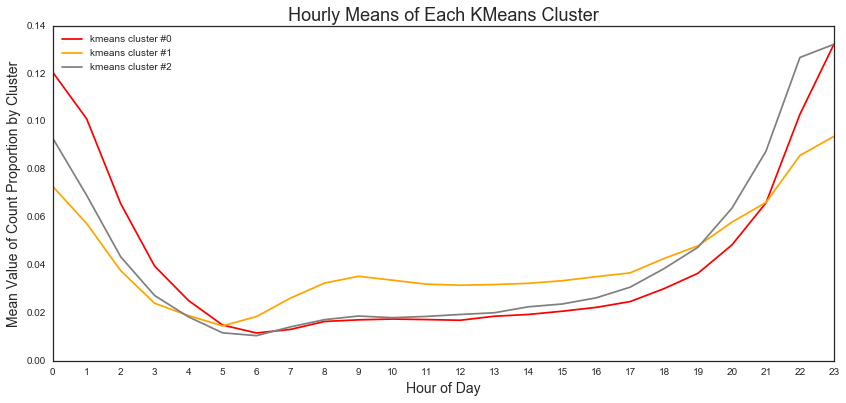

In [19]:
### create a line graph to visualize these values by cluster.
colors = ['red', 'orange', 'gray']
plt.figure(figsize=(14,6))

for i in range(k):
    plt.plot(range(len(hour_columns)), df_clusMeans_km.iloc[i,:], label='kmeans cluster #{}'.format(i), color=colors[i])

plt.title('Hourly Means of Each KMeans Cluster', size=18)
plt.xticks(range(24), range(24))
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Mean Value of Count Proportion by Cluster', fontsize=14)
plt.legend(loc='best')
plt.xlim(0,23)
plt.savefig('../output/Hourly Means of Each KMeans Cluster.png')

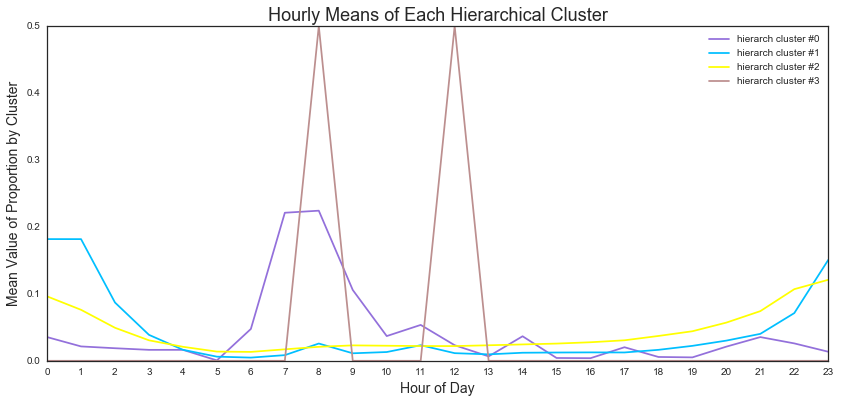

In [52]:
# line graph of this hirarchical clusters
plt.figure(figsize=(14,6))
colors = ['mediumpurple', 'deepskyblue', 'yellow', 'rosybrown']
for i in range(h):
    plt.plot(range(len(hour_columns)), df_clusMeans_hier.iloc[i,:], label='hierarch cluster #{}'.format(i), \
            color=colors[i])

plt.title('Hourly Means of Each Hierarchical Cluster', size=18)
plt.xticks(range(24), range(24))
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Mean Value of Proportion by Cluster', fontsize=14)
plt.legend(loc='best')
plt.xlim(0,23)
plt.savefig('../output/Hourly Means of Each Hierarchical Cluster.png')

## Visualize the Hour-of-Day Clustering Results on Map

In [21]:
# load shape file with demographic info
nyc_info_shape = gpd.GeoDataFrame.from_file("../output/merged_features_shapefile")

In [22]:
nyc_info_shape.head(3)

AssessTot    BldgAge   BldgDepthb  BoroCT2010   ComArea  NumBldgs  \
0  1.272389e+05  80.536313  1028.054570   5000900.0  0.315911  1.198324   
1  3.398692e+06  96.623794  2341.444145   1009800.0  0.393859  1.106109   
2  3.480757e+07  74.400000  6497.351916   1010000.0  0.917437  1.012500   

   NumFloors  allother_r  asian_pop  black_pop  comps_perp  counts  \
0   2.353380    0.073656   0.032796   0.263441    0.226344   421.0   
1   6.585209    0.009146   0.131043   0.016854    0.367651  2814.0   
2  14.668750    0.032680   0.066548   0.010101    0.516934   870.0   

   elderly_po  female_pop                                           geometry  \
0    0.059140    0.484946  POLYGON ((962269.1260375977 173705.5001831055,...   
1    0.182519    0.508231  POLYGON ((994133.507019043 214848.8975830078, ...   
2    0.146762    0.557932  POLYGON ((993108.3057861328 216013.1307983398,...   

   hisplat_po  median_hh_  tworaces_p  white_pop  
0    0.136022   28.225806    0.020430   0.124194  
1    0.028351   15.982623    0.011759   0.670368  
2    0.096257   66.606061    0.013666   0.686275

In [23]:
## Merge cluster labels in to the shapefile
nyc_clus_info_shape = pd.merge(nyc_info_shape, hour_prop, left_on='BoroCT2010', right_index=True)

In [24]:
nyc_clus_info_shape.head(3)

AssessTot    BldgAge   BldgDepthb  BoroCT2010   ComArea  NumBldgs  \
0  1.272389e+05  80.536313  1028.054570   5000900.0  0.315911  1.198324   
1  3.398692e+06  96.623794  2341.444145   1009800.0  0.393859  1.106109   
2  3.480757e+07  74.400000  6497.351916   1010000.0  0.917437  1.012500   

   NumFloors  allother_r  asian_pop  black_pop     ...       hour_16  \
0   2.353380    0.073656   0.032796   0.263441     ...      0.028504   
1   6.585209    0.009146   0.131043   0.016854     ...      0.018479   
2  14.668750    0.032680   0.066548   0.010101     ...      0.024138   

    hour_17   hour_18   hour_19   hour_20   hour_21   hour_22   hour_23  \
0  0.040380  0.054632  0.038005  0.054632  0.071259  0.140143  0.140143   
1  0.015636  0.021677  0.021322  0.050462  0.074271  0.105899  0.142502   
2  0.018391  0.028736  0.024138  0.037931  0.067816  0.062069  0.108046   

   label_km  label_hier  
0         2           3  
1         2           3  
2         1           3  

[3 rows x 45 columns]

<function matplotlib.pyplot.tight_layout>

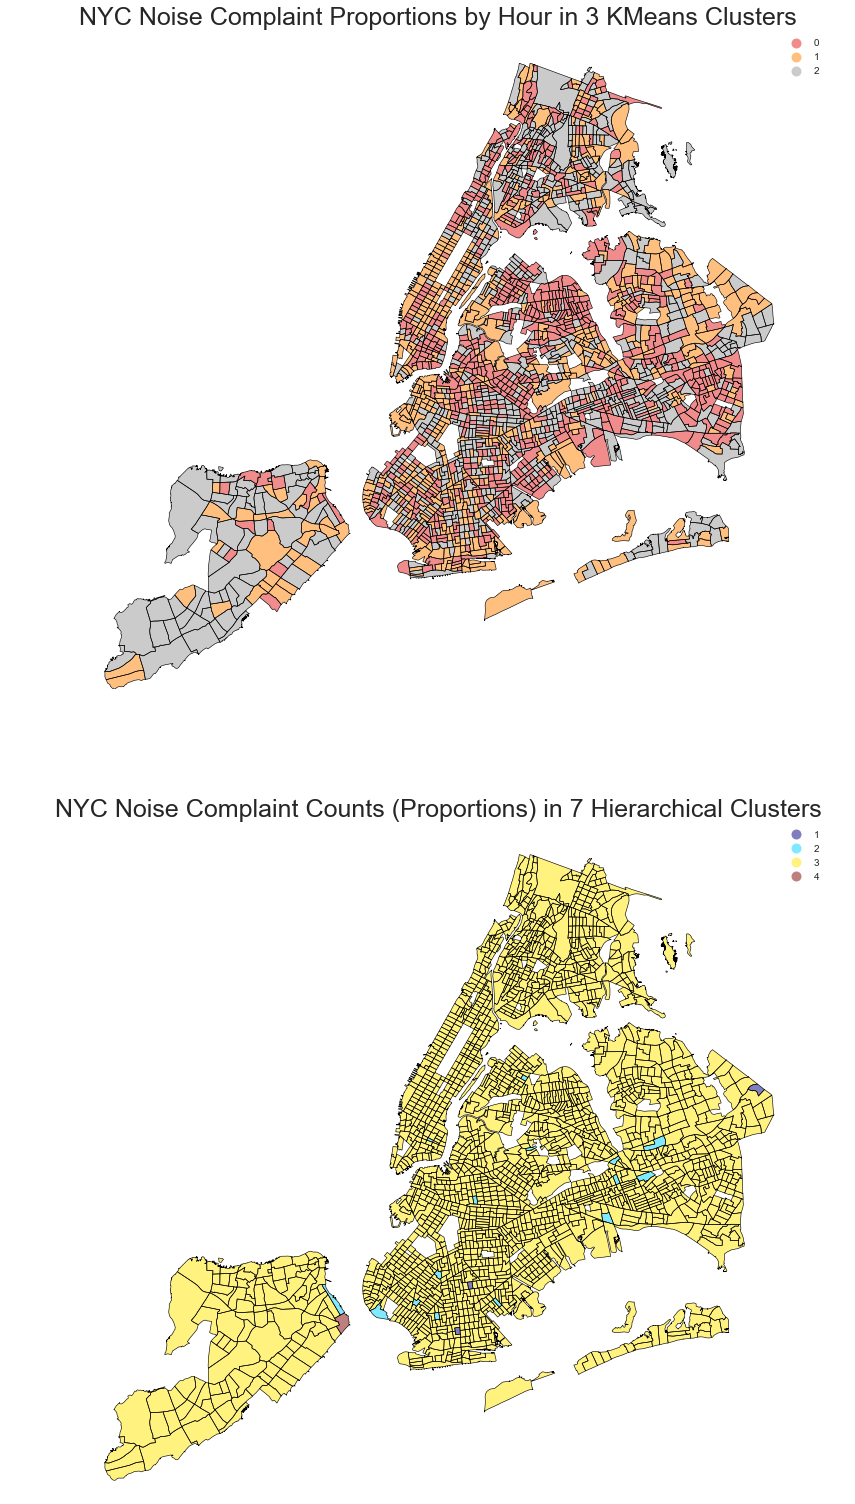

In [25]:
from matplotlib.colors import ListedColormap

#flatui = ["#3498db", "#95a5a6", "#9b59b6", "#e74c3c", "#34495e", "#2ecc71"]
#my_cmap = ListedColormap(['red', 'green', 'yellow'].as_hex())
#my_cmap = ListedColormap(sns.color_palette(flatui).as_hex())
# Plot the maps
fig = plt.figure(figsize(14, 26))

# plot kmeans clusters on map 
ax1 = fig.add_subplot(211)
nyc_clus_info_shape.plot(legend=True, cmap='Set1', column='label_km', ax=ax1, categorical=True, linewidth=0.6)
ax1.set_title('NYC Noise Complaint Proportions by Hour in 3 KMeans Clusters', fontsize=25)
ax1.set_axis_off()
plt.savefig('../output/Noise Complaint Proportions by Hour in 3 KMeans Clusters.png')

# plot Hierarchical clusters on map
ax2 = fig.add_subplot(212)
nyc_clus_info_shape.plot(legend=True, cmap='jet', column='label_hier', ax=ax2, categorical=True, linewidth=0.6)
ax2.set_title('NYC Noise Complaint Counts (Proportions) in 7 Hierarchical Clusters', fontsize=25)
ax2.set_axis_off()
plt.savefig('../output/Noise Complaint Proportions by Hour in 4 Hierarchical Clusters.png')
plt.tight_layout

In [26]:
nyc_clus_info_shape.head(2)

AssessTot    BldgAge   BldgDepthb  BoroCT2010   ComArea  NumBldgs  \
0  1.272389e+05  80.536313  1028.054570   5000900.0  0.315911  1.198324   
1  3.398692e+06  96.623794  2341.444145   1009800.0  0.393859  1.106109   

   NumFloors  allother_r  asian_pop  black_pop     ...       hour_16  \
0   2.353380    0.073656   0.032796   0.263441     ...      0.028504   
1   6.585209    0.009146   0.131043   0.016854     ...      0.018479   

    hour_17   hour_18   hour_19   hour_20   hour_21   hour_22   hour_23  \
0  0.040380  0.054632  0.038005  0.054632  0.071259  0.140143  0.140143   
1  0.015636  0.021677  0.021322  0.050462  0.074271  0.105899  0.142502   

   label_km  label_hier  
0         2           3  
1         2           3  

[2 rows x 45 columns]

In [27]:
nyc_clus_info_shape['ComArea'].groupby(nyc_clus_info_shape['label_hier']).count()

label_hier
1       3
2      15
3    2082
4       1
Name: ComArea, dtype: int64

# Examine the differences between the clusters
## CTs in Kmeans Clusters

In [28]:
nyc_clus_info_shape.columns

Index([ u'AssessTot',    u'BldgAge', u'BldgDepthb', u'BoroCT2010',
          u'ComArea',   u'NumBldgs',  u'NumFloors', u'allother_r',
        u'asian_pop',  u'black_pop', u'comps_perp',     u'counts',
       u'elderly_po', u'female_pop',   u'geometry', u'hisplat_po',
       u'median_hh_', u'tworaces_p',  u'white_pop',     u'hour_0',
           u'hour_1',     u'hour_2',     u'hour_3',     u'hour_4',
           u'hour_5',     u'hour_6',     u'hour_7',     u'hour_8',
           u'hour_9',    u'hour_10',    u'hour_11',    u'hour_12',
          u'hour_13',    u'hour_14',    u'hour_15',    u'hour_16',
          u'hour_17',    u'hour_18',    u'hour_19',    u'hour_20',
          u'hour_21',    u'hour_22',    u'hour_23',   u'label_km',
       u'label_hier'],
      dtype='object')

In [29]:
info_columns = ['counts', 'AssessTot','BldgAge', 'BldgDepthb', 'ComArea', 'NumBldgs',  'NumFloors', \
                'asian_pop',  'black_pop', 'comps_perp', 'elderly_po', 'female_pop', 'hisplat_po',\
                'median_hh_', 'tworaces_p',  'white_pop']

df_info = nyc_clus_info_shape.ix[:, info_columns]

In [30]:
max(nyc_info_shape['BoroCT2010'])

5032300.0

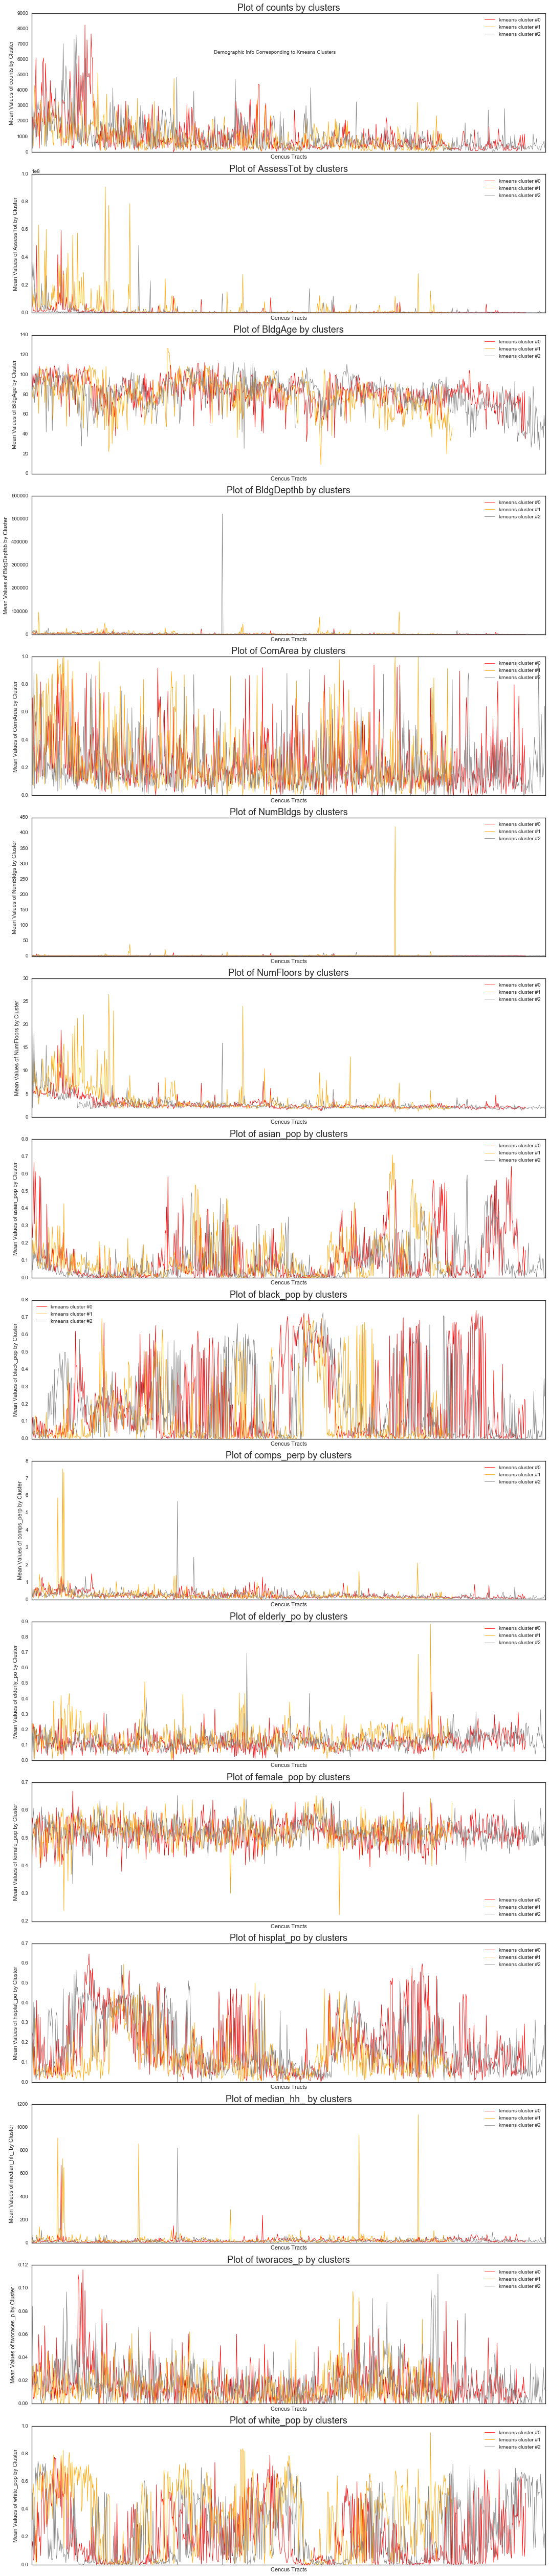

In [31]:
plt.figure(figsize=(15,70))
colors = ['red', 'orange', 'gray']
for i in range(len(info_columns)):
    col = info_columns[i]
    plt.subplot(len(info_columns), 1, i+1)
    
    for j in range(k):  # --# of clusters k=3
        df_col = nyc_clus_info_shape[nyc_clus_info_shape['label_km']==j].groupby('BoroCT2010')[col].mean()
        plt.plot(range(len(df_col)), df_col, label='kmeans cluster #{}'.format(j),\
                linewidth=0.8, alpha=1, color=colors[j])

    plt.title('Plot of {} by clusters'.format(col), size=18)
    #plt.xticks(range(min(nyc_info_shape['BoroCT2010'].astype(int)), max(nyc_info_shape['BoroCT2010'].astype(int))))
    plt.xticks(np.arange(len(df_col), 100.0), np.arange(len(df_col), 100.0), rotation=40)  #df_col.index.values
    plt.xlabel('Cencus Tracts')
    plt.ylabel('Mean Values of {} by Cluster'.format(col))
    plt.legend(loc='best')
    plt.xlim(0,len(df_col))

plt.suptitle('Demographic Info Corresponding to Kmeans Clusters')
plt.tight_layout()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).mean()


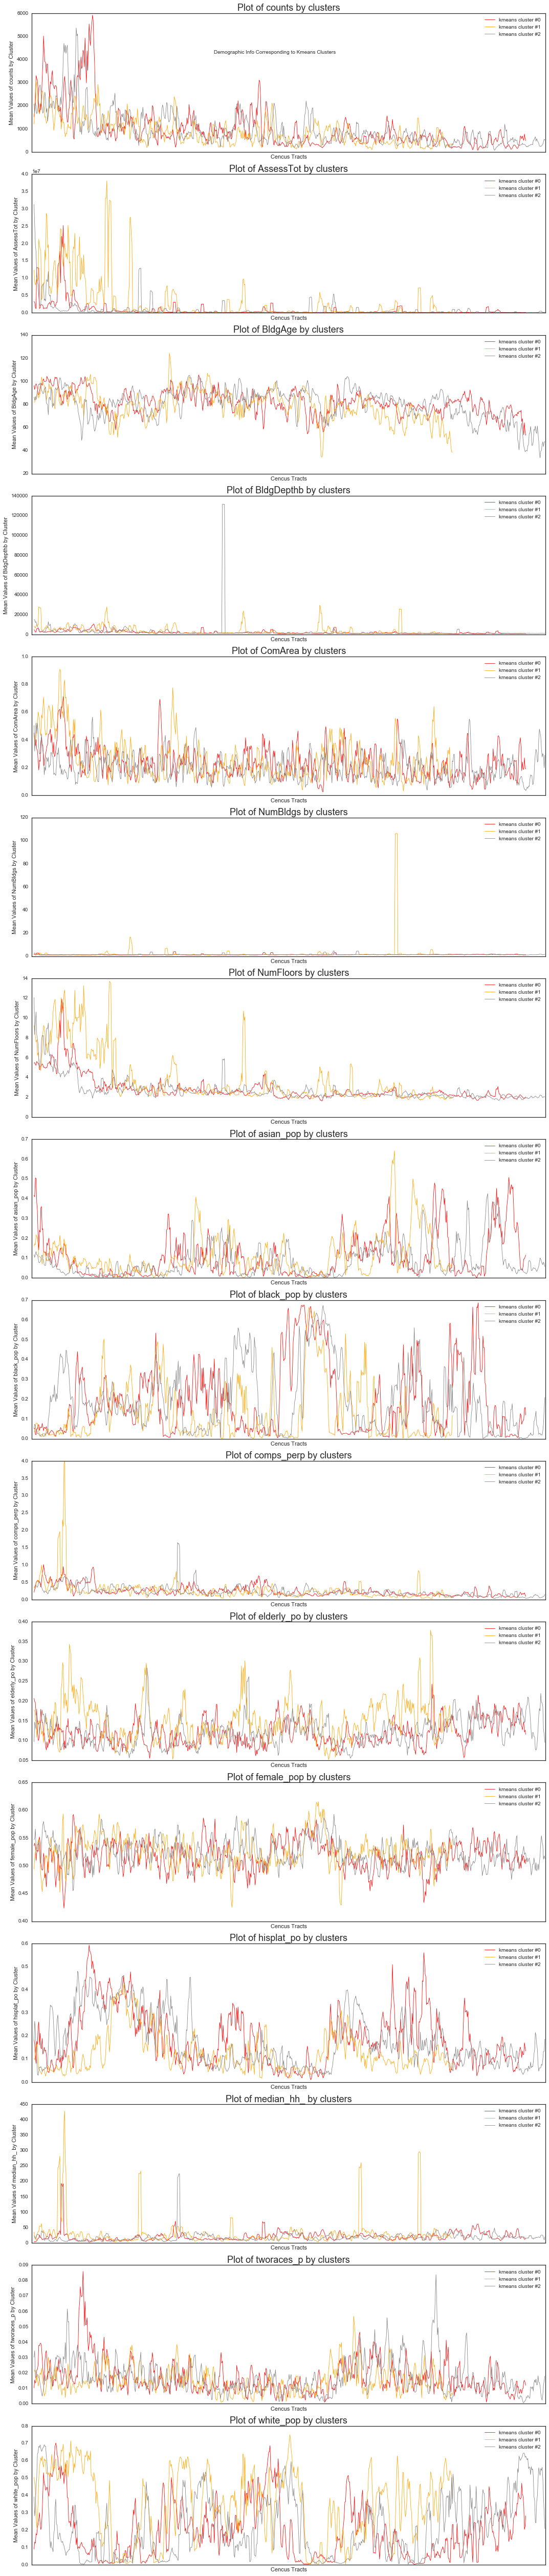

In [32]:
plt.figure(figsize=(15,70))
colors = ['red', 'orange', 'gray']
for i in range(len(info_columns)):
    col = info_columns[i]
    plt.subplot(len(info_columns), 1, i+1)
    
    for j in range(k):  # --# of clusters k=3
        df_col = nyc_clus_info_shape[nyc_clus_info_shape['label_km']==j].groupby('BoroCT2010')[col].mean()
        df_col = pd.rolling_mean(df_col, 4)
        plt.plot(range(len(df_col)), df_col, label='kmeans cluster #{}'.format(j),\
                linewidth=0.8, alpha=1, color=colors[j])

    plt.title('Plot of {} by clusters'.format(col), size=18)
    #plt.xticks(range(min(nyc_info_shape['BoroCT2010'].astype(int)), max(nyc_info_shape['BoroCT2010'].astype(int))))
    plt.xticks(np.arange(len(df_col), 100.0), np.arange(len(df_col), 100.0), rotation=40)  #df_col.index.values
    plt.xlabel('Cencus Tracts')
    plt.ylabel('Mean Values of {} by Cluster'.format(col))
    plt.legend(loc='best')
    plt.xlim(0,len(df_col))

plt.suptitle('Demographic Info Corresponding to Kmeans Clusters')
plt.tight_layout()

In [33]:
df_col.head()

BoroCT2010
1000700.0         NaN
1001001.0         NaN
1001002.0         NaN
1001300.0    0.391725
1002400.0    0.280877
Name: white_pop, dtype: float64

In [34]:
info_columns = ['counts', 'AssessTot','BldgAge', 'BldgDepthb', 'ComArea', 'NumBldgs',  'NumFloors', \
                'asian_pop',  'black_pop', 'comps_perp', 'elderly_po', 'female_pop', 'hisplat_po',\
                'median_hh_', 'tworaces_p',  'white_pop', 'BoroCT2010', 'label_km']

df_info = nyc_clus_info_shape.ix[:, info_columns]

In [35]:
df_info.head()

counts     AssessTot    BldgAge   BldgDepthb   ComArea  NumBldgs  \
0   421.0  1.272389e+05  80.536313  1028.054570  0.315911  1.198324   
1  2814.0  3.398692e+06  96.623794  2341.444145  0.393859  1.106109   
2   870.0  3.480757e+07  74.400000  6497.351916  0.917437  1.012500   
3  1247.0  3.432127e+07  81.510204  5332.846156  0.945932  1.142857   
4   924.0  2.811786e+07  83.524752  8616.885209  0.996391  1.059406   

   NumFloors  asian_pop  black_pop  comps_perp  elderly_po  female_pop  \
0   2.353380   0.032796   0.263441    0.226344    0.059140    0.484946   
1   6.585209   0.131043   0.016854    0.367651    0.182519    0.508231   
2  14.668750   0.066548   0.010101    0.516934    0.146762    0.557932   
3  11.836735   0.151731   0.020367    1.269857    0.288187    0.543788   
4  15.841584   0.428571   0.198413    7.333333    0.000000    0.238095   

   hisplat_po  median_hh_  tworaces_p  white_pop  BoroCT2010  label_km  
0    0.136022   28.225806    0.020430   0.124194   5000900.0         2  
1    0.028351   15.982623    0.011759   0.670368   1009800.0         2  
2    0.096257   66.606061    0.013666   0.686275   1010000.0         1  
3    0.053971  113.855397    0.000000   0.694501   1010400.0         1  
4    0.047619  653.658730    0.000000   0.119048   1011300.0         1

In [36]:
nyc_clus_info_shape.head(2)

AssessTot    BldgAge   BldgDepthb  BoroCT2010   ComArea  NumBldgs  \
0  1.272389e+05  80.536313  1028.054570   5000900.0  0.315911  1.198324   
1  3.398692e+06  96.623794  2341.444145   1009800.0  0.393859  1.106109   

   NumFloors  allother_r  asian_pop  black_pop     ...       hour_16  \
0   2.353380    0.073656   0.032796   0.263441     ...      0.028504   
1   6.585209    0.009146   0.131043   0.016854     ...      0.018479   

    hour_17   hour_18   hour_19   hour_20   hour_21   hour_22   hour_23  \
0  0.040380  0.054632  0.038005  0.054632  0.071259  0.140143  0.140143   
1  0.015636  0.021677  0.021322  0.050462  0.074271  0.105899  0.142502   

   label_km  label_hier  
0         2           3  
1         2           3  

[2 rows x 45 columns]

In [37]:
nyc_clus_info_shape = nyc_clus_info_shape.drop(['label_hier', 'BoroCT2010'],axis=1)

In [38]:
avg0 = nyc_clus_info_shape[nyc_clus_info_shape['label_km']==0].mean()
avg1 = nyc_clus_info_shape[nyc_clus_info_shape['label_km']==1].mean()
avg2 = nyc_clus_info_shape[nyc_clus_info_shape['label_km']==2].mean()

In [39]:
avg0.head().astype(int)

AssessTot     847238
BldgAge           81
BldgDepthb      2088
ComArea            0
NumBldgs           1
dtype: int64

In [40]:
avg1.head().astype(int)

AssessTot     3294867
BldgAge            78
BldgDepthb       3811
ComArea             0
NumBldgs            2
dtype: int64

In [41]:
avg2.head().astype(int)

AssessTot     845539
BldgAge           79
BldgDepthb      2780
ComArea            0
NumBldgs           1
dtype: int64

In [42]:
names = ['Assessed Total Valued', 'Building Age', 'Building Shape (Depth x Width)', 'Average Commercial Area (BBL)', \
 'Average Number of Buildings (BBL)', 'Average Number of Floors (BBL)', 'All Other Races', 'Asian Population', 'Black Population',
         'Complaints per Person', 'counts', 'Elderly Population', \
        'Female Population', 'Hispanic/Latino Population', 'Median Household Income' ,'Population Identifying as Two Races', \
        'White Population', 'hour_0',  'hour_1',  'hour_2',  'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',\
          'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',\
          'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23']

In [43]:
print len(names)
print len(avg0)

41
42


In [44]:
names_avg=avg0.reset_index()
names_avg['index'].unique()

array([u'AssessTot', u'BldgAge', u'BldgDepthb', u'ComArea', u'NumBldgs',
       u'NumFloors', u'allother_r', u'asian_pop', u'black_pop',
       u'comps_perp', u'counts', u'elderly_po', u'female_pop',
       u'hisplat_po', u'median_hh_', u'tworaces_p', u'white_pop', 'hour_0',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'label_km'], dtype=object)

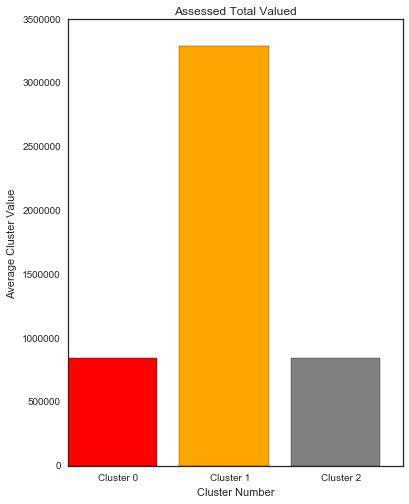

In [45]:
colors = ['red', 'orange', 'gray']
plt.figure(figsize=(6,8))
plt.bar(range(3), [elem for elem in (avg0[0], avg1[0], avg2[0])], color=colors)
plt.title(str(names[0]))
plt.xlabel('Cluster Number')
plt.ylabel('Average Cluster Value')
plt.xticks([0.45, 1.45, 2.45], ('Cluster 0', 'Cluster 1', 'Cluster 2'))
plt.savefig('../output/Assessed Total Value Bar Plot.png')

/Users/kristikorsberg/devel/venv/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


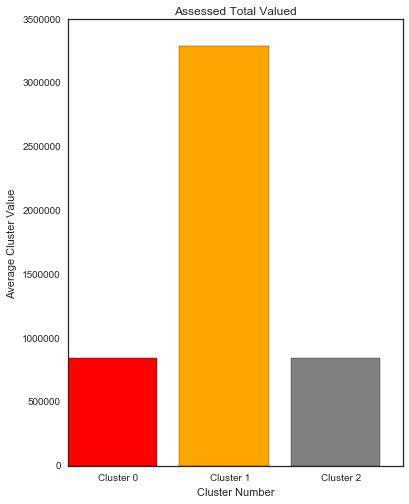

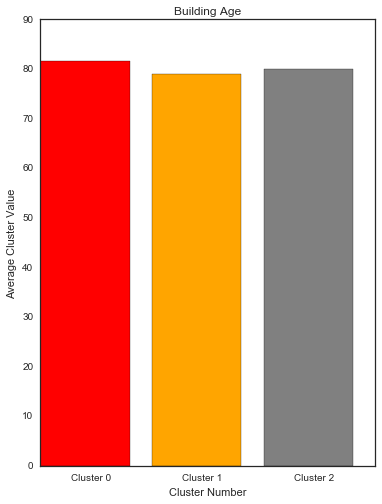

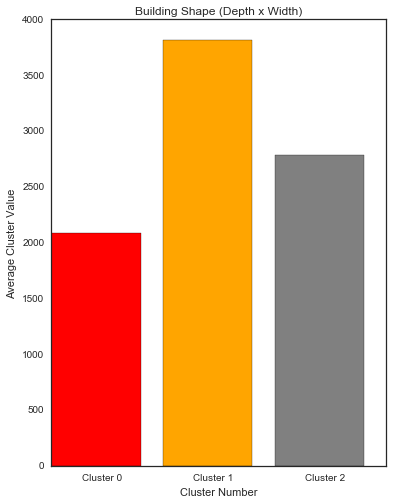

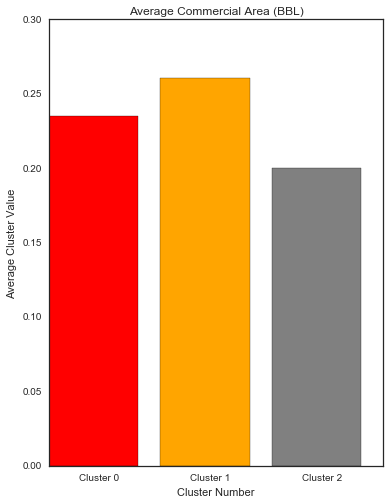

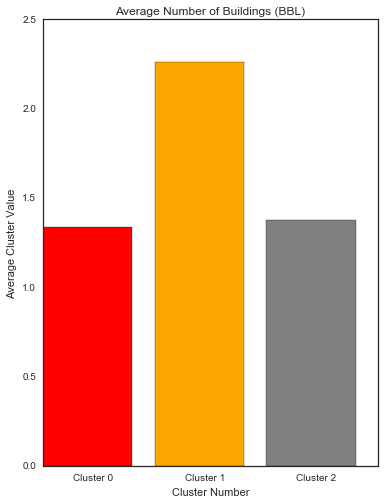

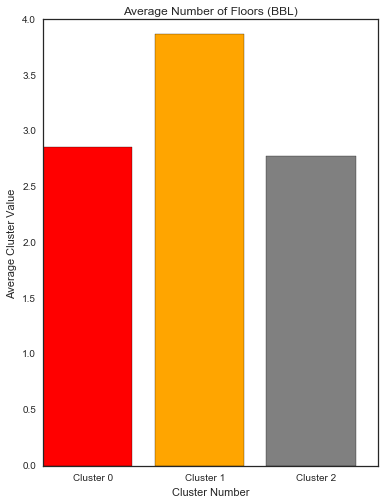

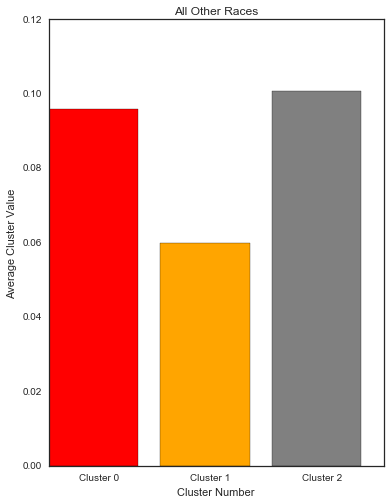

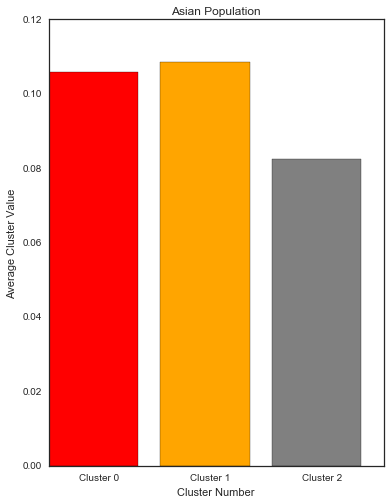

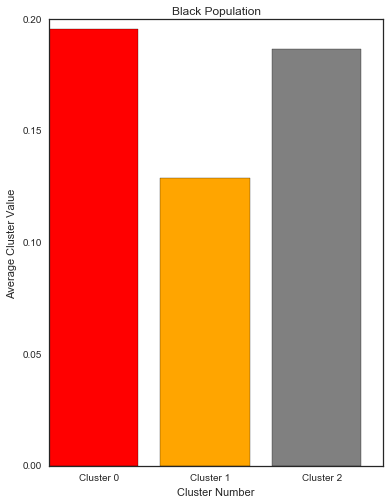

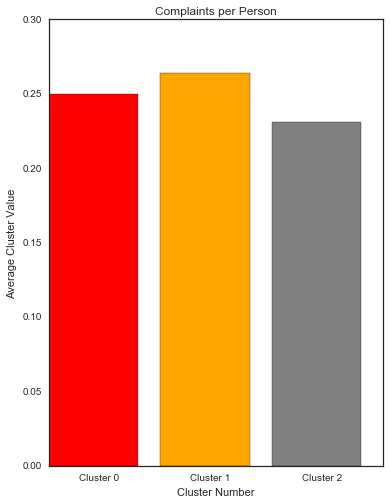

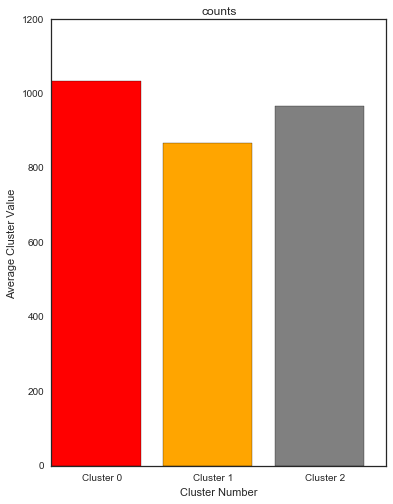

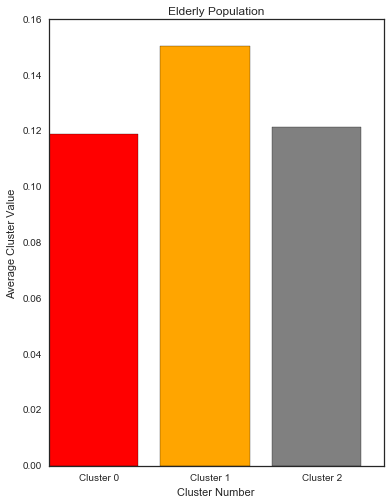

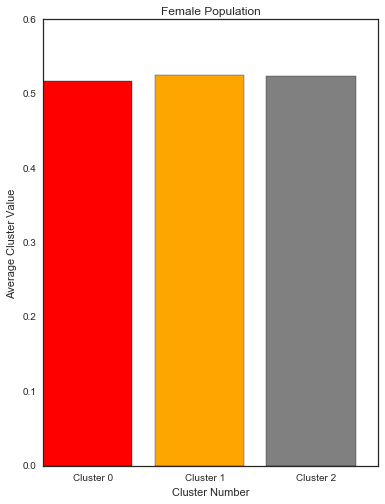

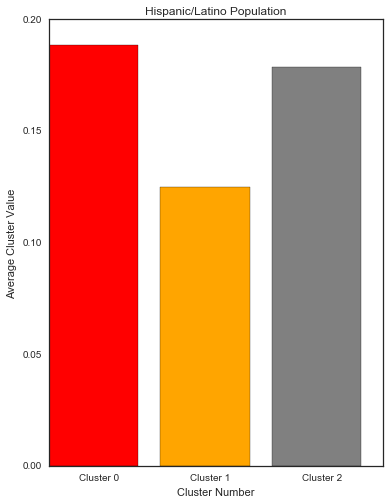

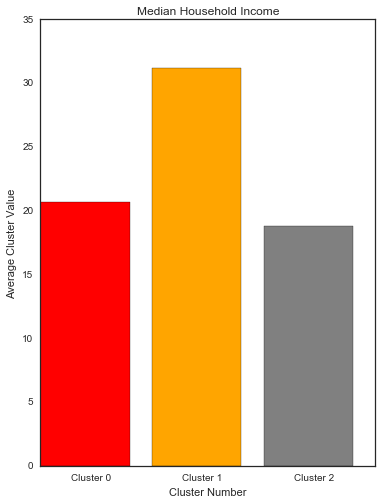

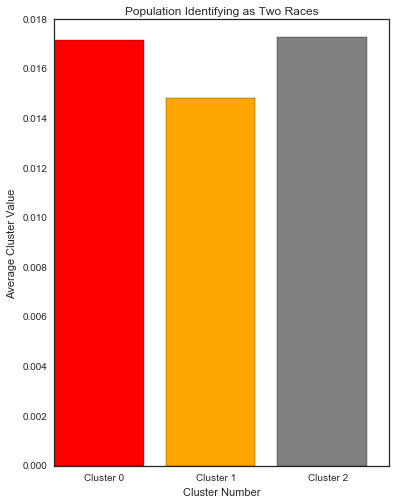

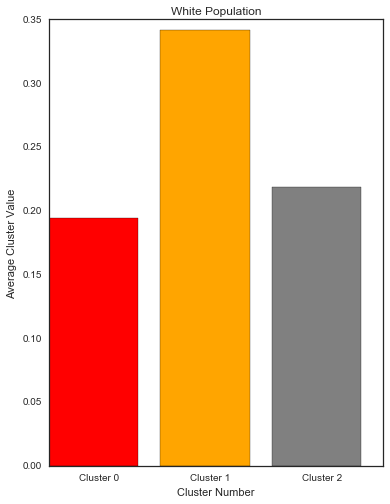

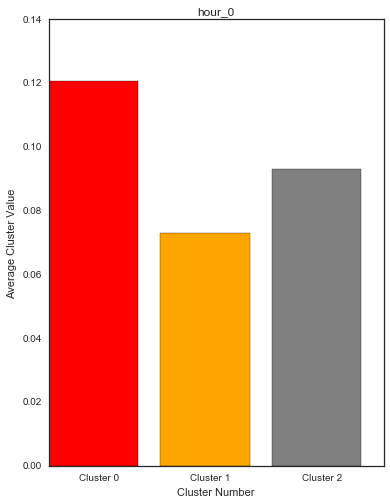

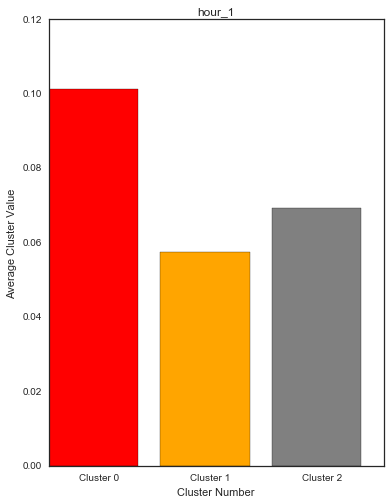

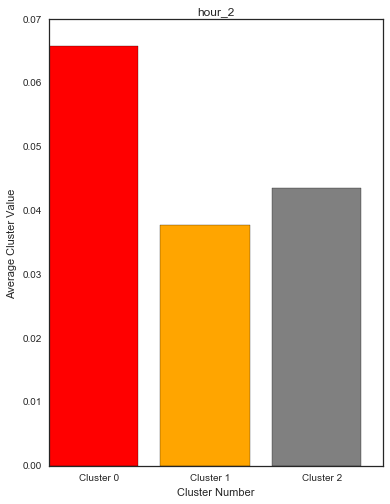

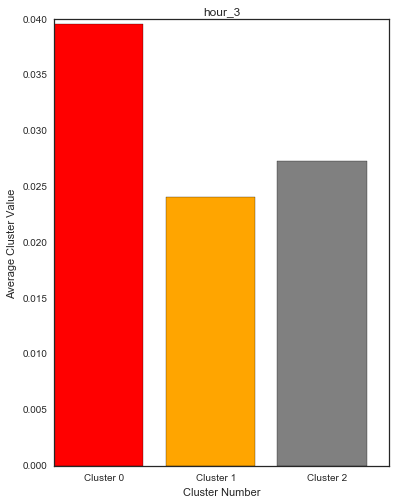

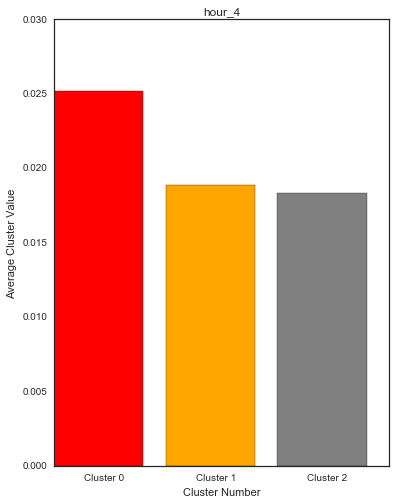

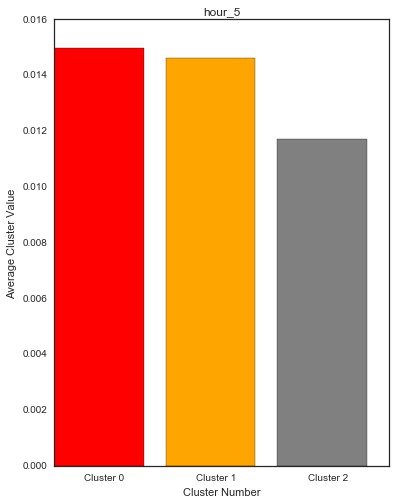

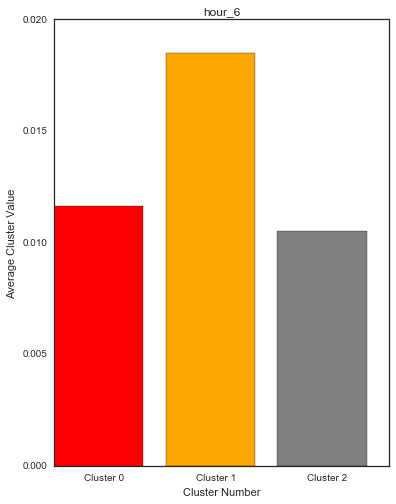

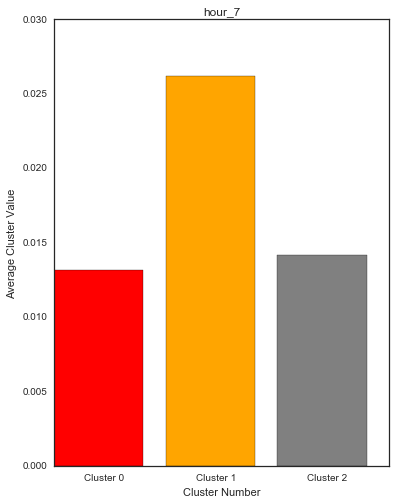

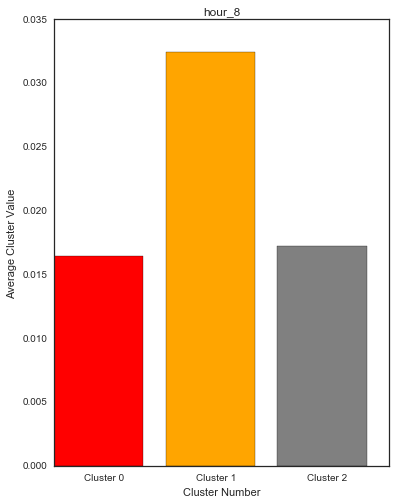

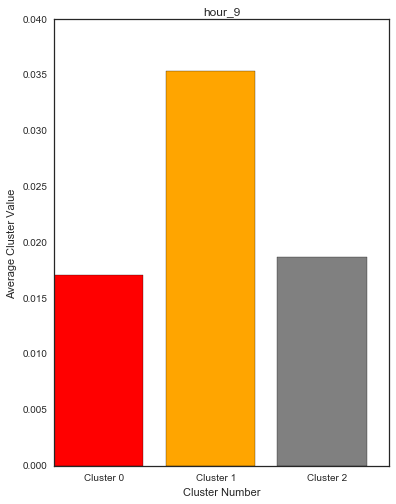

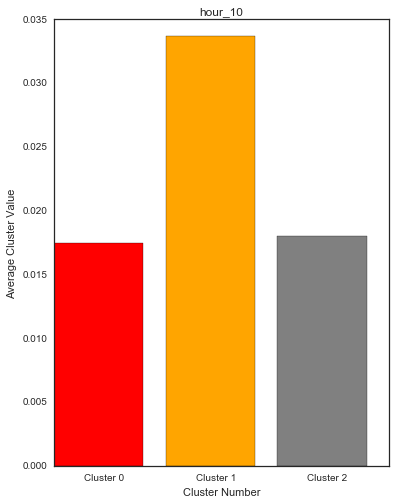

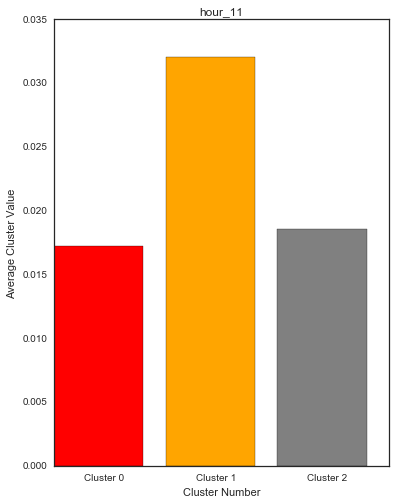

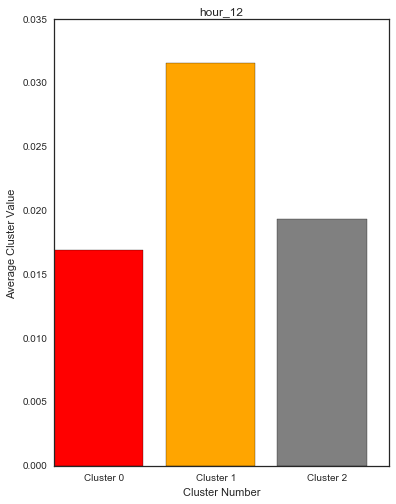

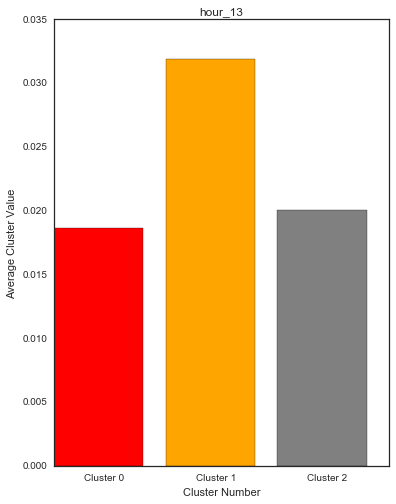

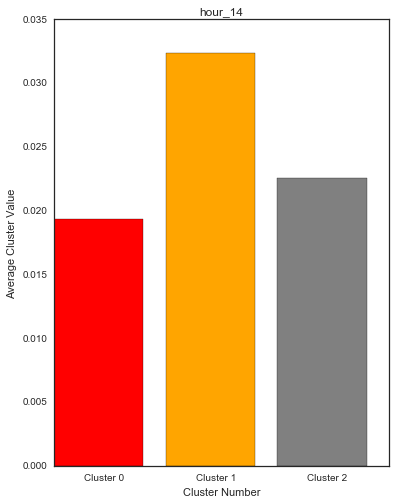

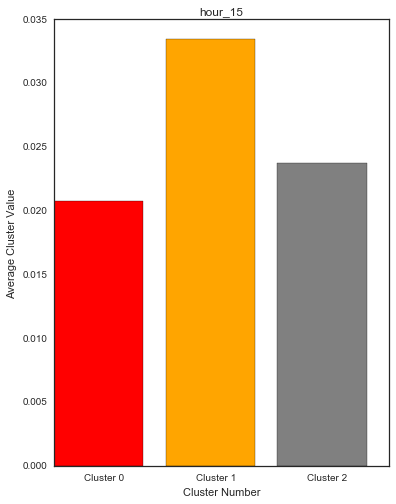

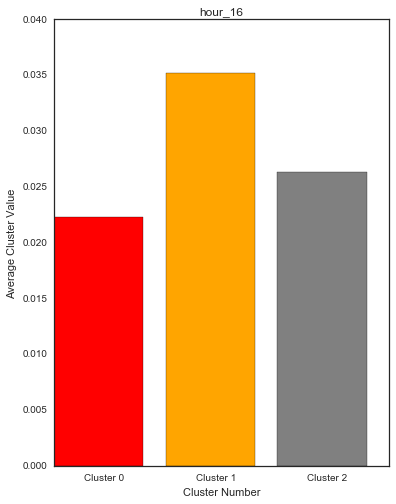

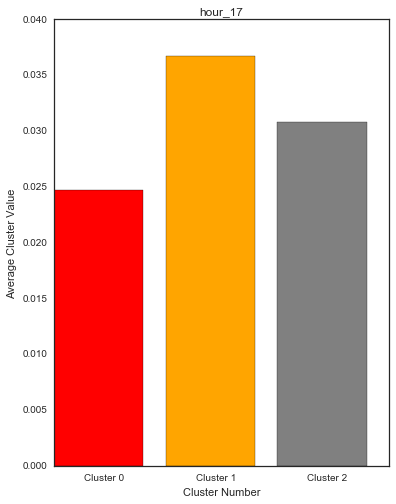

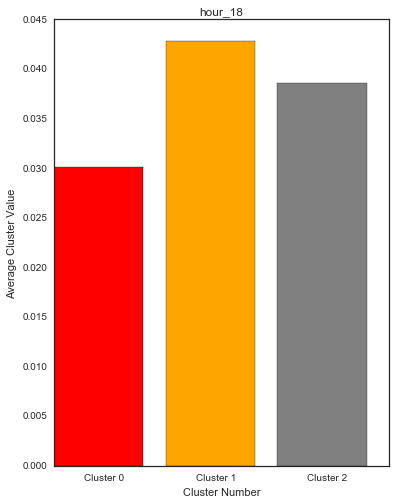

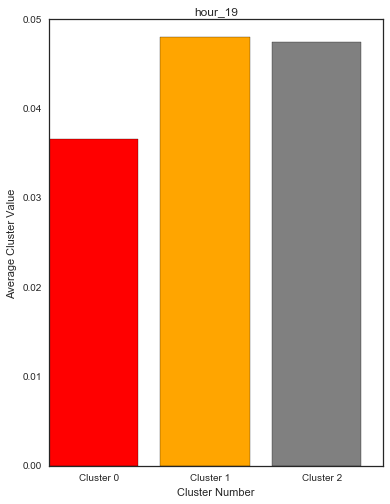

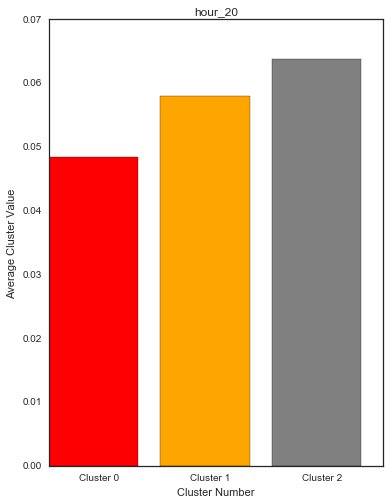

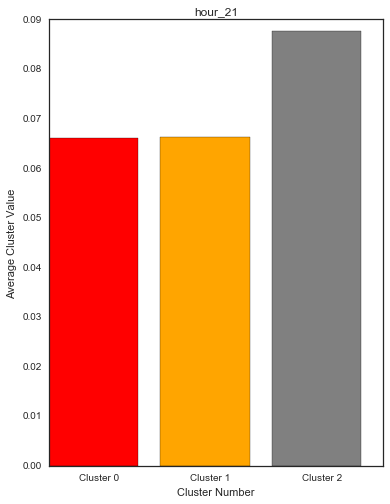

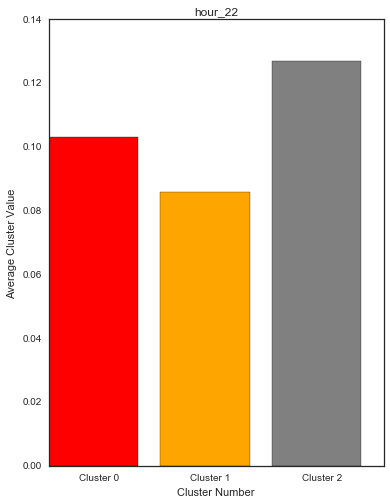

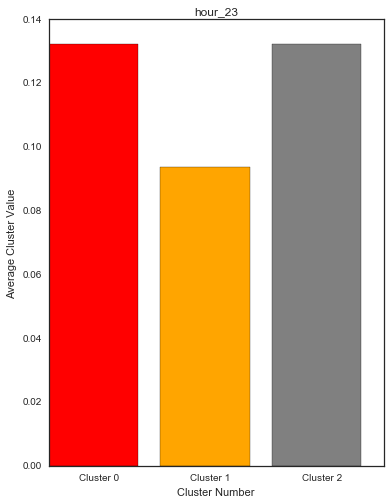

In [46]:
colors = ['red', 'orange', 'gray']
for i in range(0,len(names)):
    plt.figure(figsize=(6,8))
    plt.bar(range(3), [elem for elem in (avg0[i], avg1[i], avg2[i])], color=colors)
    plt.title(str(names[i]))
    plt.xlabel('Cluster Number')
    plt.ylabel('Average Cluster Value')
    plt.xticks([0.45, 1.45, 2.45], ('Cluster 0', 'Cluster 1', 'Cluster 2'))

In [47]:
allc = pd.read_csv('../output/all_data.csv')
shp = gpd.read_file('../data/cb_2015_36_tract_500k/cb_2015_36_tract_500k.shp')

In [48]:
shp.head(2)

AFFGEOID    ALAND  AWATER COUNTYFP        GEOID LSAD    NAME  \
0  1400000US36001000502   777446       0      001  36001000502   CT    5.02   
1  1400000US36001013507  5575232    2491      001  36001013507   CT  135.07   

  STATEFP TRACTCE                                           geometry  
0      36  000502  POLYGON ((-73.79496 42.66871, -73.790798999999...  
1      36  013507  POLYGON ((-73.802734 42.763943, -73.796492 42....

In [49]:
allc.head(2)

Unnamed: 0  BoroCT2010  counts     BldgAge  NumFloors     AssessTot  \
0           0     1000201   725.0  104.861111   5.444444  2.597126e+06   
1           1     1000202  2264.0   87.530612   5.862245  7.336789e+06   

    ComArea  NumBldgs  white_pop  black_pop  asian_pop  tworaces_pop  \
0  0.431231  1.166667   0.113221   0.041562   0.341455      0.007166   
1  0.703564  3.673469   0.166967   0.123198   0.231720      0.024073   

   hisplat_pop  female_pop  elderly_pop  median_hh_inc  BldgDepthbyFront  \
0     0.251881    0.533859     0.210319       7.352562       4926.061449   
1     0.239959    0.573378     0.205458       3.821318       8921.366638   

   allother_race_pop  comps_perperson  
0           0.150125         0.259764  
1           0.101828         0.291452

In [54]:
year = pd.read_csv('../output/year_data.csv')

In [55]:
year.head()

Unnamed: 0  BoroCT2010  BldgAge  NumFloors      AssessTot   ComArea  \
0           0     2002701     88.8   4.233333  693855.533333  0.112718   
1           1     2002701     88.8   4.233333  693855.533333  0.112718   
2           2     2002701     88.8   4.233333  693855.533333  0.112718   
3           3     2002701     88.8   4.233333  693855.533333  0.112718   
4           4     2002701     88.8   4.233333  693855.533333  0.112718   

   NumBldgs  white_pop  black_pop  asian_pop       ...         hisplat_pop  \
0  1.366667        0.0   0.185676        0.0       ...            0.384615   
1  1.366667        0.0   0.185676        0.0       ...            0.384615   
2  1.366667        0.0   0.185676        0.0       ...            0.384615   
3  1.366667        0.0   0.185676        0.0       ...            0.384615   
4  1.366667        0.0   0.185676        0.0       ...            0.384615   

   female_pop  elderly_pop  median_hh_inc  BldgDepthbyFront  \
0    0.544098     0.062666       6.682029       4661.981254   
1    0.544098     0.062666       6.682029       4661.981254   
2    0.544098     0.062666       6.682029       4661.981254   
3    0.544098     0.062666       6.682029       4661.981254   
4    0.544098     0.062666       6.682029       4661.981254   

   allother_race_pop  counts       ct    year  comps_perperson  
0           0.249668    57.0  2002701  2013.0         0.018899  
1           0.249668    64.0  2002701  2012.0         0.021220  
2           0.249668    34.0  2002701  2011.0         0.011273  
3           0.249668    54.0  2002701  2010.0         0.017905  
4           0.249668    76.0  2002701  2014.0         0.025199  

[5 rows x 21 columns]

In [56]:
year = year[year['year']==2016.0]

In [57]:
year['counts'].sum()

405282.0